In [1]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz

In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_val_score
from IPython.display import Image, display_svg, SVG
import matplotlib.pyplot as plt
import joblib
import numpy as np

model_can_be_dumped = False
target_m_rmse = 66.2
min_samples_leaf_param = 5
max_features_param = 'sqrt'
num_est = 80
validation_lookback = 7
train_start_days_past = 35
wanted_columns = [
    "high_price_1h",
    "high_price_5m",
    "high_volume_1h",
    "high_volume_5m",
    "low_price_1h",
    "low_price_5m",
    "low_volume_1h",
    "low_volume_5m",
    "player_count",
    "timestampElapsed"
  ]

In [3]:
path = Path.cwd()
Path.BASE_PATH = path
dsets_path = path.parent.parent/'fastai/datasets'
path.ls()

(#6) [Path('preprocessed_train_valid.pkl'),Path('random_forest.ipynb'),Path('.ipynb_checkpoints'),Path('decision_tree.ipynb'),Path('xg_boost.ipynb'),Path('default')]

In [4]:
df = pd.read_csv(dsets_path/'osrs_trades.csv', low_memory=False)
dep_var = 'gst'
make_date(df, 'timestamp')
df = add_datepart(df, 'timestamp')
df.columns

/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


Index(['item_id', 'gst', 'player_count', 'high_price_5m', 'low_price_5m',
       'high_volume_5m', 'low_volume_5m', 'high_price_1h', 'low_price_1h',
       'high_volume_1h', 'low_volume_1h', 'high_vol_mavg_1h',
       'low_vol_mavg_1h', 'id_y', 'limit', 'vol_ratio_1h', 'vol_ratio_5m',
       'price_ratio_5m', 'price_ratio_1h', 'avg_price_5m', 'avg_price_1h',
       'high_vol_ratio', 'low_vol_ratio', 'high_price_ratio',
       'low_price_ratio', 'avg_price_ratio', 'high_vol_differential',
       'timestampYear', 'timestampMonth', 'timestampWeek', 'timestampDay',
       'timestampDayofweek', 'timestampDayofyear', 'timestampIs_month_end',
       'timestampIs_month_start', 'timestampIs_quarter_end',
       'timestampIs_quarter_start', 'timestampIs_year_end',
       'timestampIs_year_start', 'timestampElapsed'],
      dtype='object')

In [5]:
procs = [Categorify, FillMissing]
max_day = df["timestampDayofyear"].max()
minCond = (df.timestampDayofyear>(max_day - train_start_days_past)) # day 117 is when I fixed date recording on completed_trades
maxCond = (df.timestampDayofyear<=(max_day - validation_lookback))
train_idx = np.where((maxCond) & (minCond))[0]
valid_idx = np.where(~maxCond)[0]

splits = (list(train_idx),list(valid_idx))
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
save_pickle(path/'preprocessed_train_valid.pkl', to)

/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never w

In [6]:
to = load_pickle(path/'preprocessed_train_valid.pkl')

In [7]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [8]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [9]:
def rf(xs, y, n_estimators=num_est,
       max_features=max_features_param, min_samples_leaf=min_samples_leaf_param, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [10]:
m = rf(xs, y)

In [11]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [12]:
fi = rf_feat_importance(m, xs)

In [13]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [14]:
# to_keep = fi[fi.imp>0.02].cols
# xs_imp = xs[to_keep]
# valid_xs_imp = valid_xs[to_keep]

xs_imp = xs
valid_xs_imp = valid_xs

def drop_unwanted_columns(df, required_columns):
  df = df[required_columns]
  return df
    
xs_imp = drop_unwanted_columns(xs_imp, wanted_columns)
valid_xs_imp = drop_unwanted_columns(valid_xs_imp, wanted_columns)
    
xs_imp = xs_imp.sort_index(axis=1)
valid_xs_imp = valid_xs_imp.sort_index(axis=1)

m = rf(xs_imp, y)
mean_rmse = m_rmse(m, valid_xs_imp, valid_y)
mean_rmse

66.114911

In [15]:
preds = np.stack([t.predict(valid_xs_imp) for t in m.estimators_])

/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/sklearn/base.py:

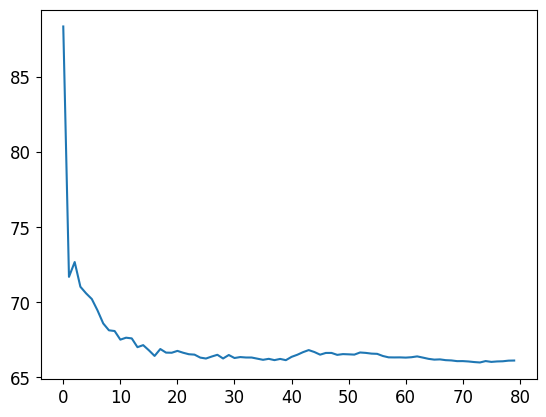

In [16]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(num_est)]);

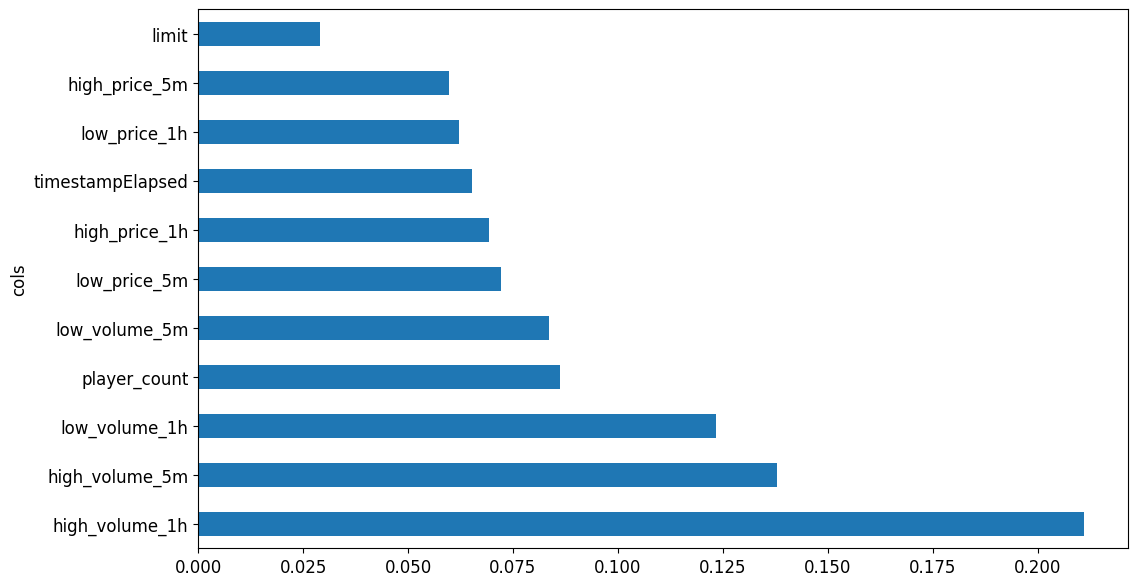

In [17]:
plot_fi(rf_feat_importance(m, xs_imp));

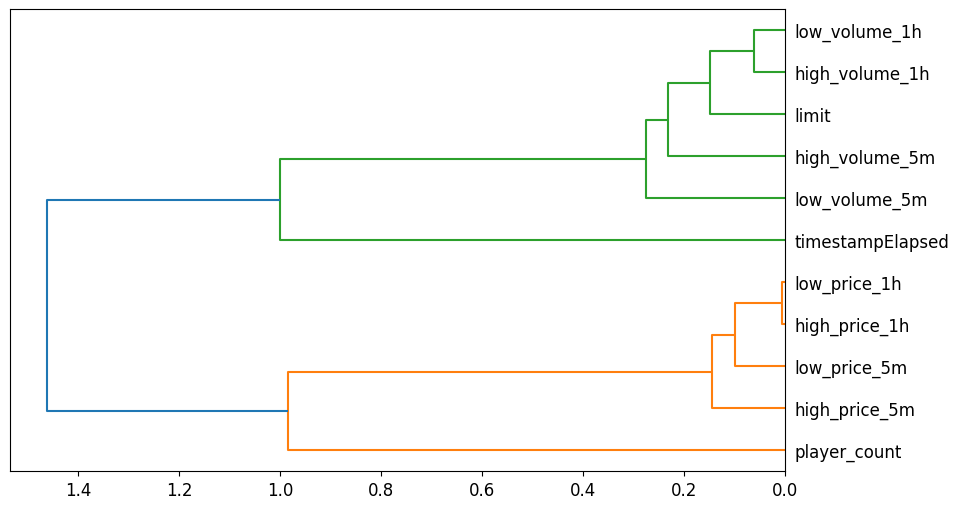

In [18]:
cluster_columns(xs_imp)

In [19]:
m.predict(valid_xs_imp.head(n=10))

array([ 41.56383899,  43.01213561, 127.6649036 ,  63.21112643,  42.62995387,  34.07194543,  56.68592528,  38.56919728,  48.85325185, 136.83977279])

In [20]:
valid_y.head(n=10)

11575     19.370001
11576     10.360000
11577     35.549999
11578     79.510002
11579     15.080000
11580      0.500000
11581     13.540000
11582      6.570000
11583      0.780000
11584    240.000000
Name: gst, dtype: float32

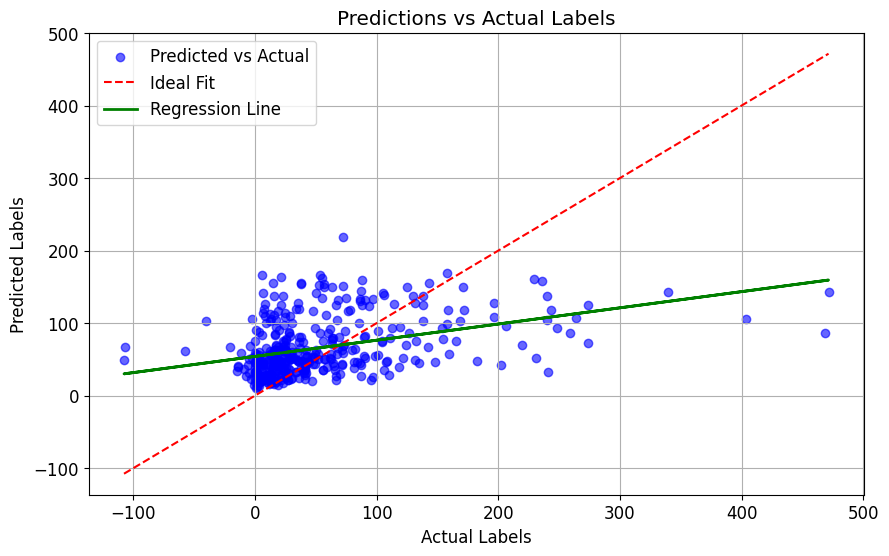

In [21]:
y_pred = m.predict(valid_xs_imp)

slope, intercept = np.polyfit(valid_y, y_pred, 1)
reg_line = slope * np.array(valid_y) + intercept

plt.figure(figsize=(10, 6))
plt.scatter(valid_y, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(valid_y), max(valid_y)], [min(valid_y), max(valid_y)], color='red', linestyle='--', label='Ideal Fit')
plt.plot(valid_y, reg_line, color='green', linestyle='-', linewidth=2, label='Regression Line')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predictions vs Actual Labels')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
xs_imp.columns

Index(['high_price_1h', 'high_price_5m', 'high_volume_1h', 'high_volume_5m',
       'limit', 'low_price_1h', 'low_price_5m', 'low_volume_1h',
       'low_volume_5m', 'player_count', 'timestampElapsed'],
      dtype='object')

In [23]:
if mean_rmse < target_m_rmse and model_can_be_dumped:
    joblib.dump(m, '/home/tristan/Documents/dev/ge_bot/prediction_api/random_forest_model.pkl')
    print("dumped new model")
else:
    print("did not dump new model")

did not dump new model


In [24]:
# xs_imp.iloc[-1].to_dict()